# Project T3: Supervised learning for location, opinion, or any available specificity prediction from the text content

# Opinion predicition

## 1. Load data and cleanse

In [113]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# data_list: [X_indices (indices for data), y_index(index for the target)]
def read_raw_data(filename='data/LA_TRANSITION_ECOLOGIQUE.csv', data_list=[11, 12, 13]):
    
    df = pd.read_csv(filename)
    data = df.iloc[:, data_list]
    data = data.dropna(axis=0, how='any')
    print ("The input questions are:")
    print (data.columns.values[:-1])
    print ("The output question is:")
    print (data.columns.values[-1])
    
    raw_X = data.iloc[:, 0]
    for i in range(1, len(data_list) - 1):
        raw_X = raw_X + " " + data.iloc[:, i]
    raw_y = data.iloc[:, -1]
    
    return raw_X, raw_y

# first two questions
raw_X, raw_y = read_raw_data(data_list=[11, 12, 13])
# the question directly related to the target
# raw_X, raw_y = read_raw_data(data_list=[14, 13])
# full data except for the one directly related to the target
# raw_X, raw_y = read_raw_data(data_list=[11, 12, 16, 17, 18, 20, 22, 23, 24, 25, 26, 13])

The input questions are:
["QUXVlc3Rpb246MTYw - Quel est aujourd'hui pour vous le problème concret le plus important dans le domaine de l'environnement ?"
 'QUXVlc3Rpb246MTYx - Que faudrait-il faire selon vous pour apporter des réponses à ce problème ?']
The output question is:
QUXVlc3Rpb246MTQ2 - Diriez-vous que votre vie quotidienne est aujourd'hui touchée par le changement climatique ?


C:\Users\Samuel\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2850: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  if self.run_code(code, result):


## 2. Preprocessing

In [114]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem.snowball import FrenchStemmer
from french_lefff_lemmatizer.french_lefff_lemmatizer import FrenchLefffLemmatizer

# remove punctuations, and tokenize
def tokenize(text):
    text_no_punctuation = re.sub(r'[.|,|\'|(|)|:]', ' ', text) #filter out all the commas, periods, and appostrophes using regex
    tokens = nltk.word_tokenize(text_no_punctuation) #generate a list of tokens from the raw text
    return tokens

def get_stopwords(type="veronis"):
    '''returns the veronis stopwords in unicode, or if any other value is passed, it returns the default nltk french stopwords'''
    if type=="veronis":
        #VERONIS STOPWORDS
        stopword_list = ["etc", "Ap.", "Apr.", "GHz", "MHz", "USD", "a", "afin", "ah", "ai", "aie", "aient", "aies", "ait", "alors", "après", "as", "attendu", "au", "au-delà", "au-devant", "aucun", "aucune", "audit", "auprès", "auquel", "aura", "aurai", "auraient", "aurais", "aurait", "auras", "aurez", "auriez", "aurions", "aurons", "auront", "aussi", "autour", "autre", "autres", "autrui", "aux", "auxdites", "auxdits", "auxquelles", "auxquels", "avaient", "avais", "avait", "avant", "avec", "avez", "aviez", "avions", "avons", "ayant", "ayez", "ayons", "b", "bah", "banco", "ben", "bien", "bé", "c", "c'", "c'est", "c'était", "car", "ce", "ceci", "cela", "celle", "celle-ci", "celle-là", "celles", "celles-ci", "celles-là", "celui", "celui-ci", "celui-là", "celà", "cent", "cents", "cependant", "certain", "certaine", "certaines", "certains", "ces", "cet", "cette", "ceux", "ceux-ci", "ceux-là", "cf.", "cg", "cgr", "chacun", "chacune", "chaque", "chez", "ci", "cinq", "cinquante", "cinquante-cinq", "cinquante-deux", "cinquante-et-un", "cinquante-huit", "cinquante-neuf", "cinquante-quatre", "cinquante-sept", "cinquante-six", "cinquante-trois", "cl", "cm", "cm²", "comme", "contre", "d", "d'", "d'après", "d'un", "d'une", "dans", "de", "depuis", "derrière", "des", "desdites", "desdits", "desquelles", "desquels", "deux", "devant", "devers", "dg", "différentes", "différents", "divers", "diverses", "dix", "dix-huit", "dix-neuf", "dix-sept", "dl", "dm", "donc", "dont", "douze", "du", "dudit", "duquel", "durant", "dès", "déjà", "e", "eh", "elle", "elles", "en", "en-dehors", "encore", "enfin", "entre", "envers", "es", "est", "et", "eu", "eue", "eues", "euh", "eurent", "eus", "eusse", "eussent", "eusses", "eussiez", "eussions", "eut", "eux", "eûmes", "eût", "eûtes", "f", "fait", "fi", "flac", "fors", "furent", "fus", "fusse", "fussent", "fusses", "fussiez", "fussions", "fut", "fûmes", "fût", "fûtes", "g", "gr", "h", "ha", "han", "hein", "hem", "heu", "hg", "hl", "hm", "hm³", "holà", "hop", "hormis", "hors", "huit", "hum", "hé", "i", "ici", "il", "ils", "j", "j'", "j'ai", "j'avais", "j'étais", "jamais", "je", "jusqu'", "jusqu'au", "jusqu'aux", "jusqu'à", "jusque", "k", "kg", "km", "km²", "l", "l'", "l'autre", "l'on", "l'un", "l'une", "la", "laquelle", "le", "lequel", "les", "lesquelles", "lesquels", "leur", "leurs", "lez", "lors", "lorsqu'", "lorsque", "lui", "lès", "m", "m'", "ma", "maint", "mainte", "maintes", "maints", "mais", "malgré", "me", "mes", "mg", "mgr", "mil", "mille", "milliards", "millions", "ml", "mm", "mm²", "moi", "moins", "mon", "moyennant", "mt", "m²", "m³", "même", "mêmes", "n", "n'avait", "n'y", "ne", "neuf", "ni", "non", "nonante", "nonobstant", "nos", "notre", "nous", "nul", "nulle", "nº", "néanmoins", "o", "octante", "oh", "on", "ont", "onze", "or", "ou", "outre", "où", "p", "par", "par-delà", "parbleu", "parce", "parmi", "pas", "passé", "pendant", "personne", "peu", "plus", "plus_d'un", "plus_d'une", "plusieurs", "pour", "pourquoi", "pourtant", "pourvu", "près", "puisqu'", "puisque", "q", "qu", "qu'", "qu'elle", "qu'elles", "qu'il", "qu'ils", "qu'on", "quand", "quant", "quarante", "quarante-cinq", "quarante-deux", "quarante-et-un", "quarante-huit", "quarante-neuf", "quarante-quatre", "quarante-sept", "quarante-six", "quarante-trois", "quatorze", "quatre", "quatre-vingt", "quatre-vingt-cinq", "quatre-vingt-deux", "quatre-vingt-dix", "quatre-vingt-dix-huit", "quatre-vingt-dix-neuf", "quatre-vingt-dix-sept", "quatre-vingt-douze", "quatre-vingt-huit", "quatre-vingt-neuf", "quatre-vingt-onze", "quatre-vingt-quatorze", "quatre-vingt-quatre", "quatre-vingt-quinze", "quatre-vingt-seize", "quatre-vingt-sept", "quatre-vingt-six", "quatre-vingt-treize", "quatre-vingt-trois", "quatre-vingt-un", "quatre-vingt-une", "quatre-vingts", "que", "quel", "quelle", "quelles", "quelqu'", "quelqu'un", "quelqu'une", "quelque", "quelques", "quelques-unes", "quelques-uns", "quels", "qui", "quiconque", "quinze", "quoi", "quoiqu'", "quoique", "r", "revoici", "revoilà", "rien", "s", "s'", "sa", "sans", "sauf", "se", "seize", "selon", "sept", "septante", "sera", "serai", "seraient", "serais", "serait", "seras", "serez", "seriez", "serions", "serons", "seront", "ses", "si", "sinon", "six", "soi", "soient", "sois", "soit", "soixante", "soixante-cinq", "soixante-deux", "soixante-dix", "soixante-dix-huit", "soixante-dix-neuf", "soixante-dix-sept", "soixante-douze", "soixante-et-onze", "soixante-et-un", "soixante-et-une", "soixante-huit", "soixante-neuf", "soixante-quatorze", "soixante-quatre", "soixante-quinze", "soixante-seize", "soixante-sept", "soixante-six", "soixante-treize", "soixante-trois", "sommes", "son", "sont", "sous", "soyez", "soyons", "suis", "suite", "sur", "sus", "t", "t'", "ta", "tacatac", "tandis", "te", "tel", "telle", "telles", "tels", "tes", "toi", "ton", "toujours", "tous", "tout", "toute", "toutefois", "toutes", "treize", "trente", "trente-cinq", "trente-deux", "trente-et-un", "trente-huit", "trente-neuf", "trente-quatre", "trente-sept", "trente-six", "trente-trois", "trois", "très", "tu", "u", "un", "une", "unes", "uns", "v", "vers", "via", "vingt", "vingt-cinq", "vingt-deux", "vingt-huit", "vingt-neuf", "vingt-quatre", "vingt-sept", "vingt-six", "vingt-trois", "vis-à-vis", "voici", "voilà", "vos", "votre", "vous", "w", "x", "y", "z", "zéro", "à", "ç'", "ça", "ès", "étaient", "étais", "était", "étant", "étiez", "étions", "été", "étée", "étées", "étés", "êtes", "être", "ô"]
    else:
        #get French stopwords from the nltk kit
        stopword_list = stopwords.words('french') #create a list of all French stopwords
    return stopword_list

# remove stop words
def filter_stopwords(text, stopword_list):
    '''normalizes the words by turning them all lowercase and then filters out the stopwords'''
    words=[w.lower() for w in text] #normalize the words in the text, making them all lowercase
    #filtering stopwords
    filtered_words = [] #declare an empty list to hold our filtered words
    for word in words: #iterate over all words from the text
        if word not in stopword_list and word.isalpha() and len(word) > 1: #only add words that are not in the French stopwords list, are alphabetic, and are more than 1 character
            filtered_words.append(word) #add word to filter_words list if it meets the above conditions
    filtered_words.sort() #sort filtered_words list
    return filtered_words

# lemmatization
def lemmatize_words(words, lemmatizer):
    lemmatized_words = []
    
    for word in words:
        lemmatized_word = lemmatizer.lemmatize(word)
        lemmatized_words.append(lemmatized_word)
        
    lemmatized_words.sort()
    return lemmatized_words

# stemming
def stem_words(words, stemmer):
    '''stems the word list using the French Stemmer'''
    #stemming words
    stemmed_words = [] #declare an empty list to hold our stemmed words
    
    for word in words:
        stemmed_word=stemmer.stem(word) #stem the word
        stemmed_words.append(stemmed_word) #add it to our stemmed word list
        
    stemmed_words.sort() #sort the stemmed_words
    return stemmed_words

# preprocess which combines all the steps above
# input: raw_X
# output: X, a list of "sentences" obtained by combining the tokens to fit the need of feature extraction functions
def preprocessing(raw_X):
    stopword_list = get_stopwords()
    lemmatizer = FrenchLefffLemmatizer()    
    stemmer = FrenchStemmer()  #create a stemmer object in the FrenchStemmer class

    X = []
    for text in raw_X:
        tokens = tokenize(text)
        filtered_words = filter_stopwords(tokens, stopword_list)
        lemmatized_words = lemmatize_words(filtered_words, lemmatizer)
        stemmed_words = stem_words(lemmatized_words, stemmer)
        X.append(' '.join(stemmed_words))
        
    return X

X = preprocessing(raw_X)

from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(raw_y)
y = le.transform(raw_y)

## 3. Feature extraction

### Bag of words representation

In [115]:
from sklearn.feature_extraction.text import CountVectorizer
count_vectorizer = CountVectorizer(min_df=8)
X_count = count_vectorizer.fit_transform(X)

### Tf-idf representation

In [116]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_count)
print (X_tfidf.shape)

(84416, 8316)


## 4. Resampling and train-test split

In [117]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state=42)
X_resampled, y_resampled = rus.fit_sample(X_tfidf, y)
print ("Before resampling, the percent of positive samples is {:.2f}".format(np.sum(y)/len(y)))
print ("After resampling, the percent of positive samples is {:.2f}".format(np.sum(y_resampled)/len(y_resampled)))

from sklearn import model_selection
X_train, X_test, y_train, y_test = model_selection.train_test_split(X_resampled, y_resampled, test_size=0.25, random_state=42)

Before resampling, the percent of positive samples is 0.68
After resampling, the percent of positive samples is 0.50


## 5. Dimensionality reduction 

### PCA

In [57]:
from sklearn.decomposition import PCA
pca = PCA(n_components=0.9)
pca.fit(X_train.toarray())
X_train_pca = pca.transform(X_train.toarray())
X_test_pca = pca.transform(X_test.toarray())
print (X_train_pca.shape)

TypeError: PCA does not support sparse input. See TruncatedSVD for a possible alternative.

### Forward feature selection

The 10 feautres with highest scores are: ['pollut' 'air' 'li' 'radical' 'économ' 'chang' 'chass' 'lobby' 'urgenc'
 'nucléair']


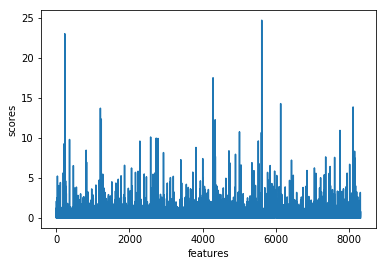

In [118]:
from sklearn.feature_selection import SelectKBest, chi2

selector = SelectKBest(chi2, k=2000)
selector.fit(X_train, y_train)
X_train_selected = selector.transform(X_train)
X_test_selected = selector.transform(X_test)
scores = selector.scores_
feature_list = list(range(len(scores)))
plt.plot(feature_list, scores)
plt.ylabel("scores")
plt.xlabel("features")
print("The 10 features with highest scores are: {}".format(
    np.array(count_vectorizer.get_feature_names())[np.argsort(-scores)[:10]]))

## 6. Classification

In [119]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
classes = ["non", "oui"]

### Naive Bayes classifier

The accuracy is: 0.5629793510324483
The precision is: 0.5591320592039086
The recall is: 0.5765298562750037
The f1-score is: 0.5676976947767727
Normalized confusion matrix
[[0.54955219 0.45044781]
 [0.42347014 0.57652986]]


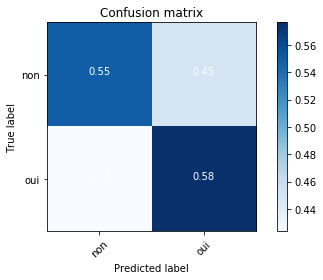

In [123]:
clf_NB = MultinomialNB()
clf_NB.fit(X_train_selected, y_train)
y_pred = clf_NB.predict(X_test_selected)
print("The accuracy is: {}".format(metrics.accuracy_score(y_test, y_pred)))
print("The precision is: {}".format(metrics.precision_score(y_test, y_pred)))
print("The recall is: {}".format(metrics.recall_score(y_test, y_pred)))
print("The f1-score is: {}".format(metrics.f1_score(y_test, y_pred)))
plot_confusion_matrix(
    metrics.confusion_matrix(y_test, y_pred),
    classes,
    normalize=True,
    title='Confusion matrix',
    cmap=plt.cm.Blues)

#### Test of the influence of the feature number

Text(0,0.5,'score')

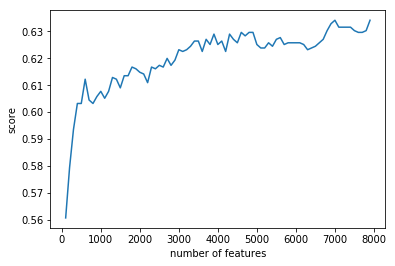

In [102]:
score_list = []
feature_number_list = np.arange(100, 8000, 100)
for i in feature_number_list:
    selector = SelectKBest(chi2, k=i)
    selector.fit(X_train, y_train)
    X_train_selected_ = selector.transform(X_train)
    X_test_selected_ = selector.transform(X_test)
    
    clf_NB = MultinomialNB()
    clf_NB.fit(X_train_selected_, y_train)
    score_list.append(clf_NB.score(X_test_selected_, y_test))

plt.plot(feature_number_list, score_list)
plt.xlabel("number of features")
plt.ylabel("score")

### Random Forest

#### Cross validation to search for the best hyperparameters

In [120]:
selector = SelectKBest(chi2, k=2000)
selector.fit(X_resampled, y_resampled)
X_resampled_selected = selector.transform(X_resampled)

from sklearn.model_selection import GridSearchCV
clf_RF = RandomForestClassifier(random_state=42)
p_grid_RF = {
    'n_estimators': list(range(10, 201, 30)),
    'max_depth': list(range(50, 150, 20))
}
grid_RF = GridSearchCV(estimator=clf_RF, param_grid=p_grid_RF, cv=5)
grid_RF.fit(X_resampled_selected, y_resampled)
print("Best Score: {}".format(grid_RF.best_score_))
print("Best params: {}".format(grid_RF.best_params_))

KeyboardInterrupt: 

#### Test with best hyperparameters

The accuracy is: 0.5751474926253687
The precision is: 0.5760702186633816
The recall is: 0.5543043413839087
The f1-score is: 0.5649777240806464
Normalized confusion matrix
[[0.59580091 0.40419909]
 [0.44569566 0.55430434]]


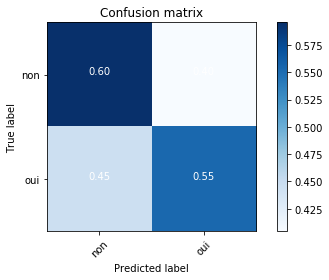

In [122]:
clf_RF = RandomForestClassifier(
    n_estimators=130,
    max_depth=130,
    random_state=42)
clf_RF.fit(X_train_selected, y_train)
y_pred = clf_RF.predict(X_test_selected)
print("The accuracy is: {}".format(metrics.accuracy_score(y_test, y_pred)))
print("The precision is: {}".format(metrics.precision_score(y_test, y_pred)))
print("The recall is: {}".format(metrics.recall_score(y_test, y_pred)))
print("The f1-score is: {}".format(metrics.f1_score(y_test, y_pred)))
plot_confusion_matrix(
    metrics.confusion_matrix(y_test, y_pred),
    classes,
    normalize=True,
    title='Confusion matrix',
    cmap=plt.cm.Blues)